In [14]:
#Qiskit Machine Learning
#A set of tools, algorithms and software for use with IBM QCs to investigate 
#how to use quantum computing to solve machine learning problems.

#Qiskit Aqua: qGAN for Loading Random Distributions
#We have a k-dimensional data sample
#We employ a quantum Generative Adversarial Network (qGAN) 
#to learn the underlying random distribution and 
#to load it into a quantum state:

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.aqua.components.optimizers import ADAM
from qiskit.aqua.components.uncertainty_models import UniformDistribution, MultivariateVariationalDistribution 
from qiskit.aqua.components.variational_forms import RY

from qiskit.aqua.algorithms import QGAN
from qiskit.aqua.components.neural_networks.quantum_generator import QuantumGenerator
from qiskit.aqua.components.neural_networks import NumPyDiscriminator

from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.components.initial_states import Custom

from qiskit import BasicAer
from torch import optim

ModuleNotFoundError: No module named 'torch'

In [15]:
#Load Training Data
#First, we need to load the k-dimensional training data samples (here k=2).

# Number training data samples
N = 100

# Load data samples from log-normal distribution with mean=1 and standard deviation=1
mu = 1
sigma = 1
real_data = np.random.lognormal(mean = mu, sigma=sigma, size=N)
real_data = [[x, int(x/2) if (x>5) else int(x)] for x in real_data ]
real_data = np.asarray(real_data)
print (real_data)
print (len(real_data))
print(real_data.shape)
print(real_data[:,0].min(),real_data[:,0].max(),real_data[:,1].min(),real_data[:,1].max())

#Next, the data resolution is set, i.e. 
#the min/max data values and the number of qubits used to represent each data dimension.
# Set the data resolution
# Set upper and lower data values as list of k min/max data values [[min_0,max_0],...,[min_k-1,max_k-1]]
bounds = [[0.,33.],[0.,16.]]
bounds = np.asarray(bounds)
print (bounds)
# Set number of qubits per data dimension as list of k qubit values[#q_0,...,#q_k-1]
num_qubits = [2,1]
k = len(num_qubits)

[[ 1.39700852  1.        ]
 [ 5.30197361  2.        ]
 [ 6.18780372  3.        ]
 [ 0.64385778  0.        ]
 [ 3.86797198  3.        ]
 [ 2.56034046  2.        ]
 [ 0.54424144  0.        ]
 [ 5.81790616  2.        ]
 [ 2.28631216  2.        ]
 [ 9.35906082  4.        ]
 [ 5.25966944  2.        ]
 [ 4.34122868  4.        ]
 [ 1.09973719  1.        ]
 [ 1.19654101  1.        ]
 [ 1.02601252  1.        ]
 [ 1.0667558   1.        ]
 [22.27517905 11.        ]
 [ 4.05020378  4.        ]
 [ 2.80139962  2.        ]
 [13.19381395  6.        ]
 [21.91910116 10.        ]
 [ 0.55394514  0.        ]
 [ 0.45063774  0.        ]
 [ 1.31293466  1.        ]
 [ 4.56256902  4.        ]
 [ 1.06227276  1.        ]
 [ 3.60687455  3.        ]
 [ 3.54079249  3.        ]
 [ 2.08627164  2.        ]
 [ 0.73430163  0.        ]
 [ 0.10839926  0.        ]
 [ 0.13516847  0.        ]
 [ 0.63637002  0.        ]
 [ 0.67370879  0.        ]
 [ 1.54334326  1.        ]
 [ 1.96196994  1.        ]
 [ 4.54751092  4.        ]
 

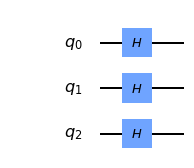

In [16]:
#Initialize the qGAN
#The qGAN consists of a quantum generator, a variational quantum circuit, and a classical discriminator,
#a neural network.
#To implement the quantum generator, we choose a depth-1 variational form that implements 
#R_Y rotations and CZ gates which takes a uniform distribution as an input state. 
#Notably, for k > 1 the generator's parameters must be chosen carefully. 
#For example, the circuit depth should be > 1 
#because higher circuit depths enable the representation of more complex structures.
#The classical discriminator is given by a 3-layer neural network that applies linear transformations, 
#leaky ReLU functions in the hidden layers and a sigmoid function in the output layer. 
#Notably, the neural network is implemented with PyTorch. 
#Please refer to https://pytorch.org/get-started/locally/ for PyTorch installation instructions.
#Here, both networks are updated with the ADAM optimization algorithm.

# Set number of training epochs - # of times training process should run
# Note: The algorithm's runtime can be shortened by reducing the number of training epochs.
num_epochs = 100
# Batch size
batch_size = 100

 # Initialize qGAN
qgan = QGAN(real_data, bounds, num_qubits, batch_size, num_epochs, snapshot_dir=None)
qgan.seed = 1
print(qgan)
# Set quantum instance to run the quantum generator
quantum_instance = QuantumInstance(backend=BasicAer.get_backend('statevector_simulator'))

# Set entangler map
entangler_map = [[0, 1],[1,2]]  #Since we are using only two qubits

# Set an initial state for the generator circuit
#init_state = UniformDistribution(sum(num_qubits), low=bounds[0], high=bounds[1])
init_state = UniformDistribution(sum(num_qubits), low=bounds[:,0], high=bounds[:,1])
q = QuantumRegister(sum(num_qubits), name='q')
qc = QuantumCircuit(q)
#Create a Quantum Circuit to represent the initial state
init_state.build(qc, q)
qc.draw(output='mpl')

In [17]:
#Create an Initial Distribution from the circuit
init_distribution = Custom(num_qubits=sum(num_qubits), circuit=qc)
#Setup the variational form
var_form = RY(int(np.sum(num_qubits)), depth=1, initial_state = init_distribution, 
              entangler_map=entangler_map, entanglement_gate='cz')
# Set generator's initial parameters
init_params = aqua_globals.random.rand(var_form._num_parameters) * 2 * np.pi
# Set generator circuit
g_circuit = MultivariateVariationalDistribution(num_qubits, var_form, init_params,low=bounds[:,0], high=bounds[:,1])

<ipython-input-17-bd8d734b5f41>:4: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  var_form = RY(int(np.sum(num_qubits)), depth=1, initial_state = init_distribution,
<ipython-input-17-bd8d734b5f41>:9: DeprecationWarning: The VariationalForm type is deprecated as argument of the MultivariateVariationalDistribution as of 0.7.0 and will be removed no earlier than 3 months after the release. You should pass an object of type QuantumCircuit instead (see qiskit.circuit.library for a collection of suitable objects).
  g_circuit = MultivariateVariationalDistribution(num_qubits, var_form, init_params,low=bounds[:,0], high=bounds[:,1])


In [18]:
print(init_distribution)
print(var_form)
print(init_params)
print(g_circuit)

[2.62022653e+00 4.52593227e+00 7.18638172e-04 1.89961158e+00
 9.22094457e-01 5.80180502e-01]


In [20]:
# Set quantum generator
qgan.set_generator(generator_circuit=g_circuit)
# Set classical discriminator neural network
discriminator = NumPyDiscriminator(len(num_qubits))
qgan.set_discriminator(discriminator)
print(qgan)

In [21]:
#Run the qGAN Training
#During the training the discriminator's and the generator's parameters are updated alternately 
#w.r.t the following loss functions: 
#$$ L_G\left(\phi, \theta\right) = -\frac{1}{m}\sum\limits_{l=1}^{m}\left[\log\left(D_{\phi}\left(g^{l}\right)\right)\right] $$ and $$ L_D\left(\phi, \theta\right) = \frac{1}{m}\sum\limits_{l=1}^{m}\left[\log D_{\phi}\left(x^{l}\right) + \log\left(1-D_{\phi}\left(g^{l}\right)\right)\right], $$ with $m$ denoting the batch size and $g^l$ describing the data samples generated by the quantum generator.

# Run qGAN
start = time.time()
qgan.run(quantum_instance)
# Runtime
end = time.time()
print('qGAN training runtime: ', (end - start)/60., ' min')

qGAN training runtime:  0.5010132630666096  min


ValueError: x and y must have same first dimension, but have shapes (100,) and (0,)

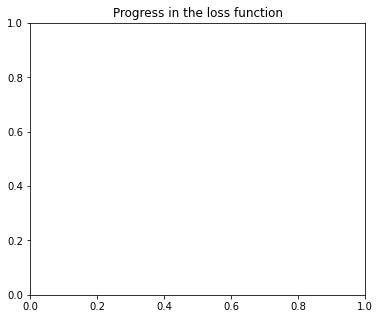

In [29]:
#Training Progress & Outcome
#Now, we plot the evolution of the generator's and the discriminator's loss functions 
#during the training as well as the progress in the relative entropy between the trained and the target distribution.
#Finally, we also compare the cumulative distribution function (CDF) of the trained distribution 
#to the CDF of the target distribution.

# Plot progress w.r.t the generator's and the discriminator's loss function
t_steps = np.arange(num_epochs)
plt.figure(figsize=(6,5))
plt.title("Progress in the loss function")
plt.plot(t_steps, qgan.g_loss, label = "Generator loss function", color = 'mediumvioletred', linewidth = 2)
plt.plot(t_steps, qgan.d_loss, label = "Discriminator loss function", color = 'rebeccapurple', linewidth = 2)
plt.grid()
plt.legend(loc = 'best')
plt.xlabel('time steps')
plt.ylabel('loss')
plt.show()

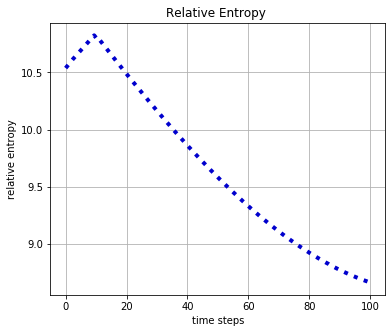

In [34]:
# Plot progress w.r.t relative entropy
plt.figure(figsize=(6,5))
plt.title("Relative Entropy ")
plt.plot(np.linspace(0, num_epochs, len(qgan.rel_entr)), qgan.rel_entr, color ='mediumblue', lw=4, ls=':')
plt.grid()
plt.xlabel('time steps')
plt.ylabel('relative entropy')
plt.show()

In [35]:
#Plot the PDF of the resulting distribution against the target distribution, i.e. log-normal
log_normal = np.random.lognormal(mean=1, sigma=1, size=100000)
log_normal = np.round(log_normal)
log_normal = log_normal[log_normal <= bounds[1]]
temp = []
for i in range(int(bounds[1]+1)):
    temp += [np.sum(log_normal==i)]
log_normal = np.array(temp / sum(temp))

plt.figure(figsize=(6,5))
plt.title("CDF")
samples_g, prob_g = qgan.generator.get_output(qgan.quantum_instance, shots=10000)
samples_g = np.array(samples_g)
samples_g = samples_g.flatten()
num_bins = len(prob_g)
plt.bar(samples_g,  np.cumsum(prob_g), color='royalblue', width= 0.8, label='simulation')
plt.plot( np.cumsum(log_normal),'-o', label='log-normal', color='deepskyblue', linewidth=4, markersize=12)
plt.xticks(np.arange(min(samples_g), max(samples_g)+1, 1.0))
plt.grid()
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend(loc='best')
plt.show()

ValueError: operands could not be broadcast together with shapes (100000,) (2,) 